In [1]:
from warnings import filters
import pandas as pd
import polars as pl
import duckdb
from datetime import datetime
import glob

# Benchmark .py file
import benchmark as bm

In [ ]:
# parameters
SINGLE_FILE = 'data/Dummy.csv'
MULTI_FILE_PATH = "data/taxi/yellow*.parquet"
MULTI_FILES = glob.glob(MULTI_FILE_PATH)

# FILTER = [("pickup_at", ">", datetime(2019, 6, 30))]
COLUMNS = ["A"]
SHOW_PLOTS = True
REPEAT_TIMES = 3
READ_SINGLE_FILE = True
if READ_SINGLE_FILE:
    TITLE_START = "Single File Benchmarks"
else:
    TITLE_START = "Multiple File Benchmarks"

# init
con = duckdb.connect()

# CSV read comparisons
Despite being row-based files, both polars and duckdb exceeds the performance of pandas dramatically through the use of
- multi-threading to achieve parallel processing
- using lazy execution plans to optimize scanning and materializing dfs
They perform pipeline fusion and streaming respectively, so it's more of a query optimizer than just a parser.

Pandas          | Avg: 1.689940s over 5 runs
Polars          | Avg: 0.187391s over 5 runs
DuckDB          | Avg: 0.067707s over 5 runs
Pandas          | Avg: 1.749507s over 5 runs
Polars          | Avg: 0.185918s over 5 runs
DuckDB          | Avg: 0.075172s over 5 runs
Pandas          | Avg: 1.275617s over 5 runs
Polars          | Avg: 0.141657s over 5 runs
DuckDB          | Avg: 0.076583s over 5 runs
Pandas          | Avg: 1.312144s over 5 runs


C:\Users\lacatt\AppData\Local\Temp\ipykernel_27736\1268641503.py:55: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .select(pl.count())


Polars          | Avg: 0.146329s over 5 runs
DuckDB          | Avg: 0.203932s over 5 runs

Single File Benchmarks: Read All Data
   Method  Time (s)
0  Pandas  1.689940
1  Polars  0.187391
2  DuckDB  0.067707


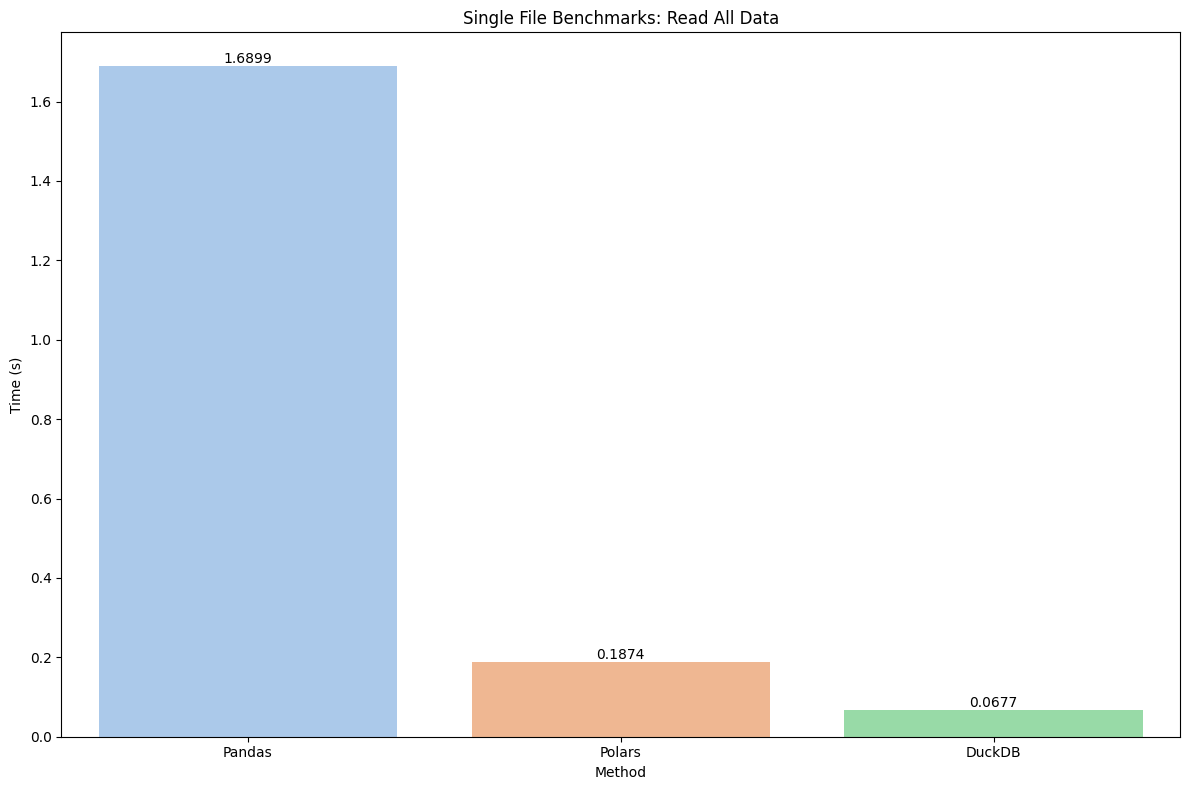


Single File Benchmarks: Filter & Return All Columns
   Method  Time (s)
0  Pandas  1.749507
1  Polars  0.185918
2  DuckDB  0.075172


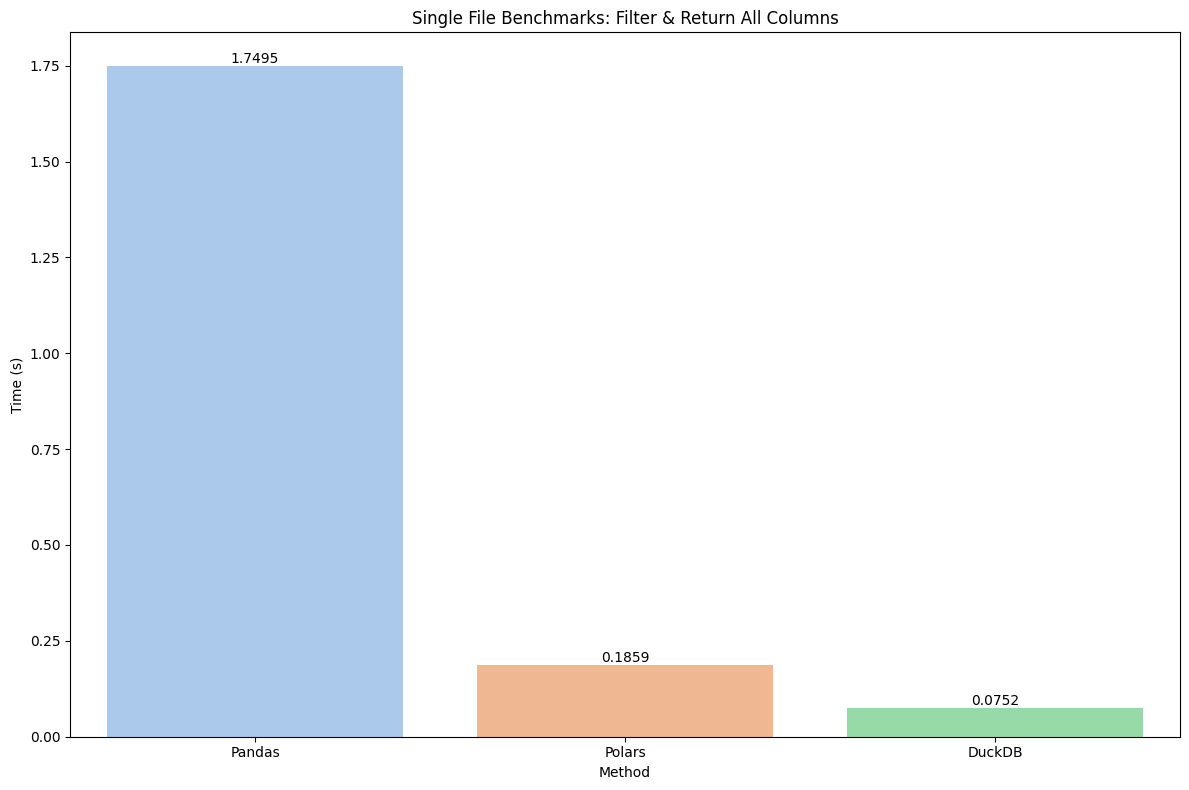


Single File Benchmarks: Filter & Return One Column
   Method  Time (s)
0  Pandas  1.275617
1  Polars  0.141657
2  DuckDB  0.076583


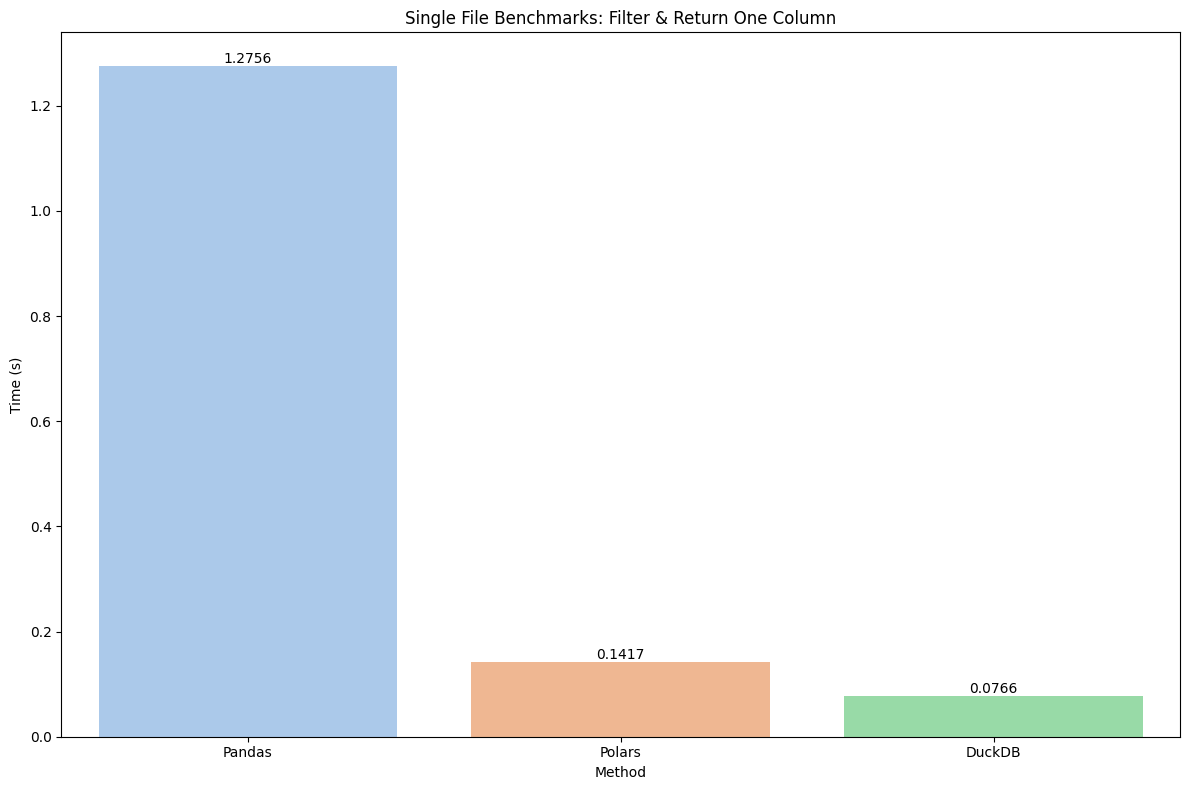


Single File Benchmarks: Filtered Row Count
   Method  Time (s)
0  Pandas  1.312144
1  Polars  0.146329
2  DuckDB  0.203932


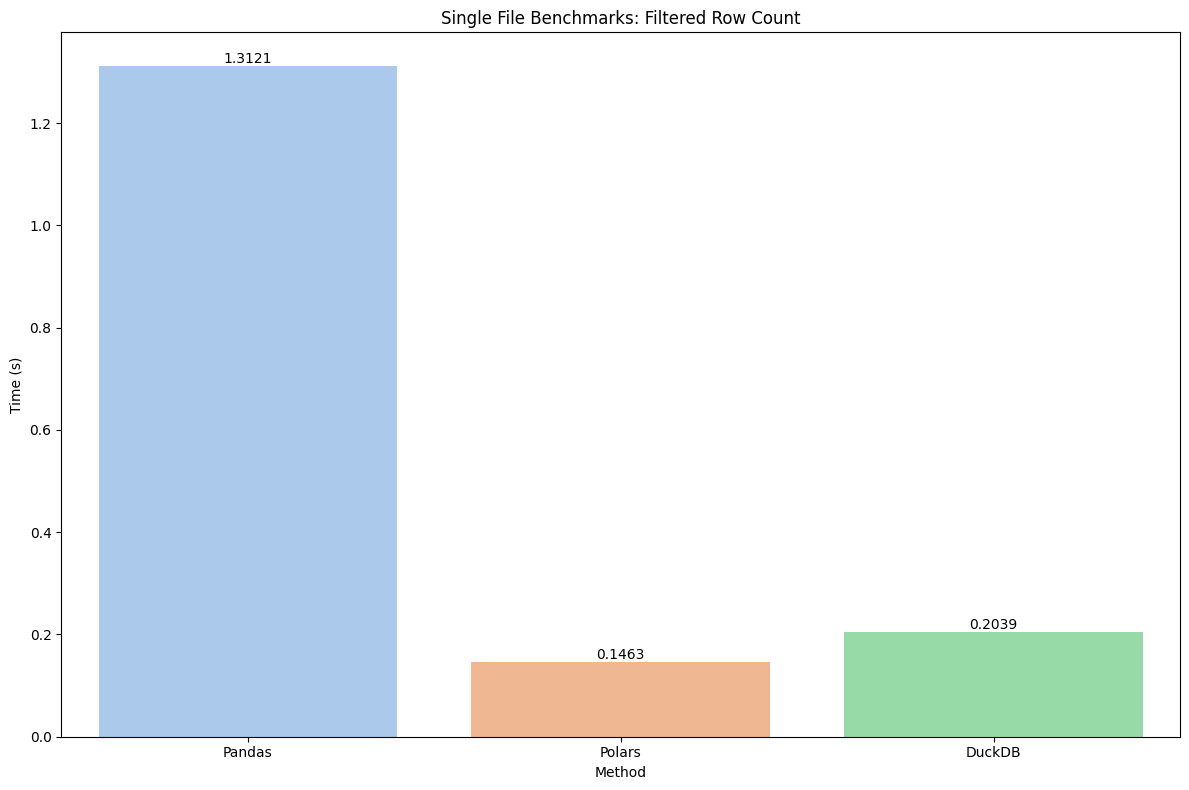

In [ ]:
# reading csv files
if READ_SINGLE_FILE:
    ### Functions to compare on speeds - for one parquet SINGLE_FILE 'alltaxi.parquet'
    # Ordinary read functions on all data without filters
    def pandas_read_all():
        return pd.read_csv(SINGLE_FILE)
    def polars_read_all():
        return pl.scan_csv(SINGLE_FILE).collect()
    def duckdb_read_all():
        return con.execute(f"SELECT * FROM '{SINGLE_FILE}'")

    # Filtering function 1 - read ALL columns with filter on pickup_at > '2019-06-30'
    def pandas_filter_all():
        df = pd.read_csv(SINGLE_FILE)
        return df[df["A"] > 800]
    def polars_filter_all():
        return (
            pl.scan_csv(SINGLE_FILE)
            .filter(pl.col("A") > 800)
            .collect()
        )
    def duckdb_filter_all():
        return con.execute(f"""
            SELECT *
            FROM '{SINGLE_FILE}'
            WHERE A > 800
        """)

    # Filtering function 2 - read ONE column with filter on pickup_at > '2019-06-30'
    def pandas_filter_one():
        df = pd.read_csv(SINGLE_FILE, usecols=['A'])
        return df[df["A"] > 800]
    def polars_filter_one():
        return (
            pl.scan_csv(SINGLE_FILE).select(COLUMNS)
            .filter(pl.col("A") > 800)
            .collect()
        )
    def duckdb_filter_one():
        return con.execute(f"""
            SELECT A
            FROM '{SINGLE_FILE}'
            WHERE A > 800
        """)

    # Filtering function 3 - count rows with filter on pickup_at > '2019-06-30'
    # Note: only selecting one column for optimal row count performance
    def pandas_filter_count():
        df = pd.read_csv(SINGLE_FILE, usecols=['A'])
        return len(df[df["A"] > 800])
    def polars_filter_count():
        return len(
            pl.scan_csv(SINGLE_FILE)
            .filter(pl.col("A") > 800)
            .select(pl.len())
            .collect()
        )
    def duckdb_filter_count():
        return con.execute(f"""
            SELECT count(*)
            FROM '{SINGLE_FILE}'
            WHERE A > 800
        """)

    ### Run benchmarks
    # Benchmark: Read all data (no filter)
    results_all = {
        "Pandas": bm.timing(pandas_read_all, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_read_all, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_read_all, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter column and return all columns
    results_filter_all = {
        "Pandas": bm.timing(pandas_filter_all, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_all, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_all, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter column and return that one column
    results_filter_one = {
        "Pandas": bm.timing(pandas_filter_one, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_one, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_one, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter count
    results_filter_count = {
        "Pandas": bm.timing(pandas_filter_count, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_count, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_count, runs=REPEAT_TIMES, label="DuckDB"),
    }

    ### Plotting results
    # Plot each benchmark group
    bm.plot_results(results_all, f"{TITLE_START}: Read All Data", show=SHOW_PLOTS)
    bm.plot_results(results_filter_all, f"{TITLE_START}: Filter & Return All Columns", show=SHOW_PLOTS)
    bm.plot_results(results_filter_one, f"{TITLE_START}: Filter & Return One Column", show=SHOW_PLOTS)
    bm.plot_results(results_filter_count, f"{TITLE_START}: Filtered Row Count", show=SHOW_PLOTS)

In [ ]:
# reading parquet files
if READ_SINGLE_FILE:
    ### Functions to compare on speeds - for one parquet SINGLE_FILE 'alltaxi.parquet'
    # Ordinary read functions on all data without filters
    def pandas_read_all():
        return pd.read_parquet(SINGLE_FILE)
    def polars_read_all():
        return pl.scan_parquet(SINGLE_FILE).collect()
    def duckdb_read_all():
        return con.execute(f"SELECT * FROM '{SINGLE_FILE}'")

    # Filtering function 1 - read ALL columns with filter on pickup_at > '2019-06-30'
    def pandas_filter_all():
        return pd.read_parquet(SINGLE_FILE, filters=[("pickup_at", ">", datetime(2019, 6, 30))])
    def polars_filter_all():
        return (
            pl.scan_parquet(SINGLE_FILE)
            .filter(pl.col("pickup_at").dt.date() > pl.datetime(2019, 6, 30))
            .collect()
        )
    def duckdb_filter_all():
        return con.execute(f"""
            SELECT *
            FROM '{SINGLE_FILE}'
            WHERE pickup_at > '2019-06-30'
        """)

    # Filtering function 2 - read ONE column with filter on pickup_at > '2019-06-30'
    def pandas_filter_one():
        return pd.read_parquet(SINGLE_FILE, columns=['pickup_at'], filters=[("pickup_at", ">", datetime(2019, 6, 30))])
    def polars_filter_one():
        return (
            pl.scan_parquet(SINGLE_FILE).select(COLUMNS)
            .filter(pl.col("pickup_at").dt.date() > pl.datetime(2019, 6, 30))
            .collect()
        )
    def duckdb_filter_one():
        return con.execute(f"""
            SELECT pickup_at
            FROM '{SINGLE_FILE}'
            WHERE pickup_at > '2019-06-30'
        """)

    # Filtering function 3 - count rows with filter on pickup_at > '2019-06-30'
    # Note: only selecting one column for optimal row count performance
    def pandas_filter_count():
        return len(pd.read_parquet(SINGLE_FILE, columns=['pickup_at'], filters=[("pickup_at", ">", datetime(2019, 6, 30))]))
    def polars_filter_count():
        return len(
            pl.scan_parquet(SINGLE_FILE)
            .filter(pl.col("pickup_at").dt.date() > pl.datetime(2019, 6, 30))
            .select(pl.count())
            .collect()
        )
    def duckdb_filter_count():
        return con.execute(f"""
            SELECT count(*)
            FROM '{SINGLE_FILE}'
            WHERE pickup_at > '2019-06-30'
        """)

    ### Run benchmarks
    # Benchmark: Read all data (no filter)
    results_all = {
        "Pandas": bm.timing(pandas_read_all, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_read_all, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_read_all, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter column and return all columns
    results_filter_all = {
        "Pandas": bm.timing(pandas_filter_all, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_all, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_all, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter column and return that one column
    results_filter_one = {
        "Pandas": bm.timing(pandas_filter_one, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_one, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_one, runs=REPEAT_TIMES, label="DuckDB"),
    }

    # Benchmark: Filter count
    results_filter_count = {
        "Pandas": bm.timing(pandas_filter_count, runs=REPEAT_TIMES, label="Pandas"),
        "Polars": bm.timing(polars_filter_count, runs=REPEAT_TIMES, label="Polars"),
        "DuckDB": bm.timing(duckdb_filter_count, runs=REPEAT_TIMES, label="DuckDB"),
    }

    ### Plotting results
    # Plot each benchmark group
    bm.plot_results(results_all, f"{TITLE_START}: Read All Data", show=SHOW_PLOTS)
    bm.plot_results(results_filter_all, f"{TITLE_START}: Filter & Return All Columns", show=SHOW_PLOTS)
    bm.plot_results(results_filter_one, f"{TITLE_START}: Filter & Return One Column", show=SHOW_PLOTS)
    bm.plot_results(results_filter_count, f"{TITLE_START}: Filtered Row Count", show=SHOW_PLOTS)

Pandas          | Avg: 0.810457s over 5 runs
Polars          | Avg: 0.219535s over 5 runs


CatalogException: Catalog Error: Table Function with name read_ipc does not exist!
Did you mean "read_csv"?

LINE 1: SELECT * FROM read_ipc('data/taxi/yellow_tripdata_2022-01.feather')
                      ^